##Start Spark Session

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


## Mount Google Drive into this runtime 

To access your config file, you need to mount your google drive into this runtime. To do that, run the following cells.
This will prompt a URL with an authentication code. After you go to the URL and insert 

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My Drive/data_final_project/mental_health_ML

/content/gdrive/My Drive/data_final_project/mental_health_ML


## Create config.py file


*   List item
*   List item


In the **mental_health_ML** directory, create a file called **config.py** and add the following contents:

```bash
ACCESS_ID='AWS_ACCESS_KEY_ID'
ACCESS_KEY='AWS_SECRET_ACCESS_KEY'
BUCKET_NAME='S3_BUCKET_NAME'
```

Replace AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, and S3_BUCKET_NAME with their actual values. This file is in the .gitignore so that it won't be committed to GitHub.

In [0]:
# Database credentials
from config import DB_USERNAME, DB_PASSWORD, DB_ENDPOINT

# Used for making database connection.
! pip install sqlalchemy

from sqlalchemy import create_engine

In [0]:
! pip install psycopg2-binary

rds_connection_string = f"{DB_USERNAME}:{DB_PASSWORD}@{DB_ENDPOINT}:5432/mental_health_tech_db"
engine = create_engine(f'postgresql://{rds_connection_string}')

     |████████████████████████████████| 2.9MB 3.5MB/s 


In [0]:
engine.table_names()

['survey_responses']

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
df = pd.read_sql_query('select * from survey_responses', con=engine)
df.head()

,id,year,number_employees,is_tech_company,employer_provides_mental_health_benefits,knows_options_available,employer_formally_discussed_mental_health,employer_offers_resources,is_anonymity_protected_by_employer,level_difficulty_asking_for_leave,comfortable_talking_physical_mental_coworkers,comfortable_discussing_with_supervisor,has_discussed_with_employer,conversation_with_employer,comfortable_discussing_with_coworkers,has_discussed_with_coworkers,conversation_with_coworkers,had_coworker_discuss_mental_health,conversation_coworker_had,employer_physical_health_importance,employer_mental_health_importance,has_previous_employers,is_previous_employer_tech_company,previous_employer_provided_mental_health_benefits,aware_options_from_previous_employer,previous_employer_formally_discussed_mental_health,previous_employer_offered_resources,is_anonymity_protected_by_previous_employer,comfortable_talking_physical_mental_previous_employer,comfortable_discussing_with_previous_supervisor,has_discussed_with_previous_employer,conversation_with_previous_employer,willing_discuss_with_previous_coworkers,has_discussed_with_previous_coworkers,conversation_with_previous_coworkers,had_previous_coworker_discuss_mental_health,conversation_previous_coworker_had,previous_employer_physical_health_importance,previous_employer_mental_health_importance,currently_has_mental_health_disorder,has_been_diagnosed,had_disorder_in_past,sought_treatment_for_mental_health,has_family_history,interferes_with_work_treated,interferes_with_work_not_treated,observations_of_others,willingness_to_share,physical_health_in_interview,comments_physical_health_in_interview,mental_health_in_interview,comments_mental_health_in_interview,is_openly_identified,how_think_coworkers_would_react,experienced_unsupportive_response,comments_unsupportive_response,experienced_supportive_response,comments_supportive_response,tech_industry_level_support,comments_improve_mental_health_support,additional_comments,interferes_with_work,discussing_mental_health_has_consequences,discussing_physical_health_has_consequences,employer_takes_mental_seriously_as_physical,observed_consequences_for_coworkers,discussing_mental_has_consequences_previous_employer,discussing_physical_has_consequences_previous_employer,previous_employer_took_mental_seriously_as_physical,observed_consequences_for_previous_coworkers,feels_mental_health_hurts_career,thinks_coworkers_view_negatively
0,0,2019,26-100,True,I don't know,No,Yes,Yes,I don't know,Very easy,Physical health,Yes,False,None,Yes,True,Mainly was a general 'maybe I should go see so...,True,They talked about how they are active in the m...,5.0,5.0,True,False,I don't know,N/A (was not aware),Some did,"Yes, they all did",I don't know,Physical health,Some of my previous supervisors,False,None,At some of my previous employers,False,None,True,None,8.0,5.0,Don't Know,None,No,False,No,Not applicable to me,Not applicable to me,No,8.0,Yes,If it impacts work I would bring it up,Maybe,If I feel it's under control I likely wouldn't...,False,8.0,No,None,Maybe/Not sure,None,4.0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1,2019,26-100,True,Yes,No,No,Yes,Yes,I don't know,Physical health,Maybe,False,None,Maybe,True,I prefer only to say that a recent coworker ha...,True,I prefer only to say that a recent coworker ha...,5.0,7.0,True,False,"Yes, they all did",I was aware of some,Some did,Some did,"Yes, always",Physical health,Some of my previous supervisors,False,None,At some of my previous employers,True,I prefer only to say that those previous cowor...,True,None,8.0,5.0,Possibly,None,Possibly,False,Yes,Sometimes,Often,No,7.0,No,I do not trust that the potential employer wou...,No,I do not trust that the potential employer wou...,False,7.0,"Yes, I observed","As I recall, a direct supervisor was identifie...","Yes, I experienced",None,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2,2019,26-100,True,I don't know,No,No,I don't know,I don't k

In [0]:
#Creating data frame for machine learning
mlData = df[["number_employees", "is_tech_company", "employer_provides_mental_health_benefits", "employer_offers_resources", "employer_formally_discussed_mental_health", "is_anonymity_protected_by_employer", "experienced_supportive_response", "sought_treatment_for_mental_health"]]
mlData.head()

,number_employees,is_tech_company,employer_provides_mental_health_benefits,employer_offers_resources,employer_formally_discussed_mental_health,is_anonymity_protected_by_employer,experienced_supportive_response,sought_treatment_for_mental_health
0,26-100,True,I don't know,Yes,Yes,I don't know,Maybe/Not sure,False
1,26-100,True,Yes,Yes,No,Yes,"Yes, I experienced",False
2,26-100,True,I don't know,I don't know,No,I don't know,"Yes, I observed",False
3,100-500,True,I don't know,Yes,Yes,Yes,"Yes, I observed",False
4,26-100,True,I don't know,I don't know,I don't know,I don't know,No,False


In [0]:
#Replace "Don't know" responses with "I don't know"
mlData2 = mlData.replace("Don't know", "I don't know")

In [0]:
mlData3 = pd.get_dummies(mlData2, drop_first=True)
mlData3.head()

,is_tech_company,sought_treatment_for_mental_health,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,False,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,False,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Decision Trees

In [0]:
from sklearn import tree

#Load data frame
mlData3.head()

,is_tech_company,sought_treatment_for_mental_health,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,False,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,False,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Create df for Target data
target = mlData3["sought_treatment_for_mental_health"]
target_names = ["False", "True"]

In [0]:
# Create df for X
data = mlData3.drop("sought_treatment_for_mental_health", axis=1)
feature_names = data.columns
data.head()

,is_tech_company,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Split X in to training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [0]:
# Create model and test
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7834890965732088

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7897196261682243

In [0]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.19188998728079767, 'experienced_supportive_response_No'),
 (0.11325265707626972, 'experienced_supportive_response_Maybe/Not sure'),
 (0.07481423581635895, 'employer_provides_mental_health_benefits_Yes'),
 (0.06952790813955878, 'experienced_supportive_response_Yes, I observed'),
 (0.06280262438536549, 'is_anonymity_protected_by_employer_Yes'),
 (0.059210779542534196, 'is_tech_company'),
 (0.0563715125844161, 'employer_offers_resources_No'),
 (0.041438643885314146, 'employer_offers_resources_Yes'),
 (0.04087230389292811, 'employer_formally_discussed_mental_health_No'),
 (0.035918481496367824, 'number_employees_26-100'),
 (0.03564581038158124, 'number_employees_100-500'),
 (0.03384094803484037, 'employer_formally_discussed_mental_health_Yes'),
 (0.031268603469382567, 'number_employees_More than 1000'),
 (0.02813473299913694, 'employer_provides_mental_health_benefits_No'),
 (0.02741753058190488, 'number_employees_6-25'),
 (0.027408775996990445, 'experienced_supportive_response_Yes, I e

# KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

#Load data frame
mlData3.head()

,is_tech_company,sought_treatment_for_mental_health,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,False,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,False,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Create df for Target data
target = mlData3["sought_treatment_for_mental_health"]
target_names = ["False", "True"]

In [0]:
# Create df for X
data = mlData3.drop("sought_treatment_for_mental_health", axis=1)
data.head()

,is_tech_company,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Split X in to training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [0]:
#Loop through different k values to find highest accuracy
train_scores = []
test_scores = []
for k in range(1, 20, 2):
		knn = KNeighborsClassifier(n_neighbors=k)
		knn.fit(X_train, y_train)
		train_score = knn.score(X_train, y_train)
		test_score = knn.score(X_test, y_test)
		train_scores.append(train_score)
		test_scores.append(test_score)
		print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

k: 1, Train/Test Score: 0.910/0.779
k: 3, Train/Test Score: 0.883/0.799
k: 5, Train/Test Score: 0.861/0.804
k: 7, Train/Test Score: 0.849/0.804
k: 9, Train/Test Score: 0.837/0.796
k: 11, Train/Test Score: 0.834/0.802
k: 13, Train/Test Score: 0.830/0.802
k: 15, Train/Test Score: 0.824/0.808
k: 17, Train/Test Score: 0.817/0.802
k: 19, Train/Test Score: 0.814/0.805


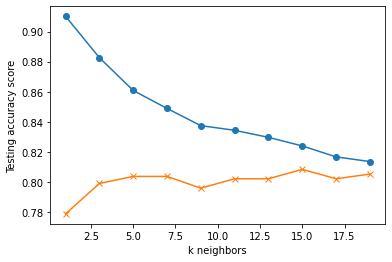

In [0]:
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker='x')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [0]:
# Run with "best" K value
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
print('k=15 Test Acc: %.4f' % knn.score(X_test, y_test))

k=15 Test Acc: 0.8084


# Logistic Regression

In [0]:
#Load data frame
mlData3.head()

,is_tech_company,sought_treatment_for_mental_health,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,True,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,True,False,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,True,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,True,False,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
#Dummy code boolean variables
mlData4 = mlData3.replace(True, 1)
mlData4.head()

,is_tech_company,sought_treatment_for_mental_health,number_employees_100-500,number_employees_26-100,number_employees_500-1000,number_employees_6-25,number_employees_More than 1000,employer_provides_mental_health_benefits_No,employer_provides_mental_health_benefits_Not eligible for coverage / NA,employer_provides_mental_health_benefits_Yes,employer_offers_resources_No,employer_offers_resources_Yes,employer_formally_discussed_mental_health_No,employer_formally_discussed_mental_health_Yes,is_anonymity_protected_by_employer_No,is_anonymity_protected_by_employer_Yes,experienced_supportive_response_Maybe/Not sure,experienced_supportive_response_No,"experienced_supportive_response_Yes, I experienced","experienced_supportive_response_Yes, I observed"
0,1.0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,1.0,0.0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
2,1.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Assign data and target
X = mlData4.drop("sought_treatment_for_mental_health", axis=1)
y = mlData4["sought_treatment_for_mental_health"]

In [0]:
print(np.array(X[:10]))

[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]]


In [0]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
# Creating regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Train model
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Validate model
print(f"Training Data Source: {classifier.score(X_train, y_train)}")
print(f"Testing Data Source: {classifier.score(X_test, y_test)}")

Training Data Source: 0.8359293873312564
Testing Data Source: 0.822429906542056


In [0]:
# Make predictions
predictions = classifier.predict(X_test)

print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
First 10 Actual labels: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [0]:
# Dataframe of predictions and actual
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1.0,1.0
1,0.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
637,0.0,0.0
638,1.0,1.0
639,1.0,1.0
640,1.0,0.0


In [0]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, predictions)
c_matrix

array([[ 44,  80],
       [ 34, 484]])

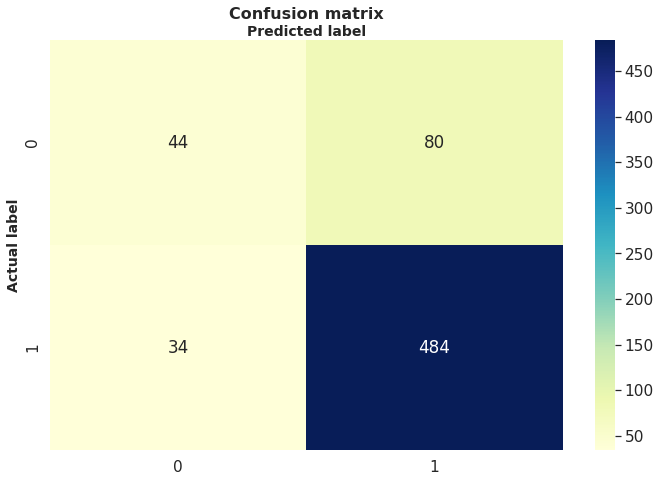

In [0]:
import seaborn as sns
class_names=[0,1] 
fig, ax = plt.subplots(figsize=(10,7))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.title('Confusion matrix', y=1.1, fontsize=16, fontweight='bold')
plt.ylabel('Actual label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.savefig("cfn_matrix.jpg")
plt.tight_layout()
plt.show()

In [0]:
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall", metrics.recall_score(y_test, predictions))

Accuracy: 0.822429906542056
Precision: 0.8581560283687943
Recall 0.9343629343629344


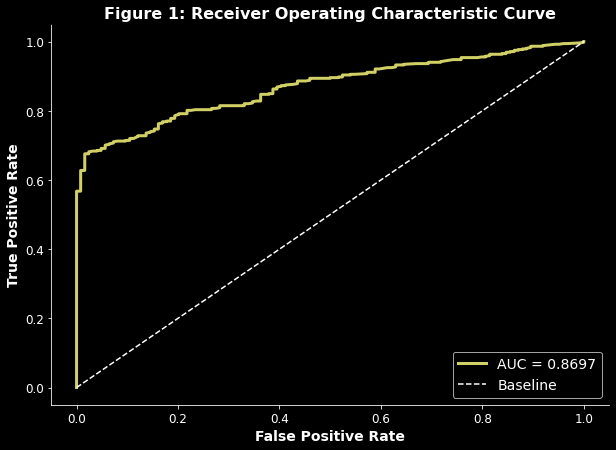

In [0]:
import sklearn.metrics as metrics

# Calculating ROC-AUC Curve
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Creating Graph
fig, ax = plt.subplots(figsize=(10,7))
fig.patch.set_facecolor('#000000')
ax.set_facecolor('#000000')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
plt.plot(fpr, tpr, color="#D0D066", linewidth=3, label='AUC = %0.4f' %roc_auc)
plt.plot([0,1], [0,1], linestyle="--", color="#ffffff", label='Baseline')
#plt.xlim([0, 1])
#plt.ylim([0,1])
legend = plt.legend(loc = 'lower right', facecolor="#000000", fontsize=14)
plt.setp(legend.get_texts(), color="#ffffff")
plt.tick_params(axis='both', labelsize=12, color="#ffffff", labelcolor="#ffffff")
plt.title("Figure 1: Receiver Operating Characteristic Curve", fontsize=16, fontweight='bold', color="#ffffff")
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold', color="#ffffff")
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color="#ffffff")
plt.savefig("roccurve.jpg", facecolor='#000000', edgecolor="#000000")

plt.show()

In [0]:
new_data = np.array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]])
predictions = classifier.predict(new_data)
print("Classes are either 0 (False) or 1 (True)")
print(f"The new point was classified as: {predictions}")

Classes are either 0 (False) or 1 (True)
The new point was classified as: [1.]


In [0]:
#Save the model to disk
import pickle

filename = "ml_model.pkl"
with open(filename, 'wb') as file:
  pickle.dump(classifier, file)
